### IMPORTING THE REQUIRED MODULES

Simply importing the required module for the project

In [1]:
!pip install transformers 
!pip install datasets
!pip install pynvml
!pip install evaluate 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import transformers
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import os
import nltk
import torch
import evaluate
import sys
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### UTILS FUNCTION TO WORK WITH GPU

The code below outlines some utilis function for working with the GPU and select the gpu as DEVICE to use in case it is available.

In [4]:
# define utils functions to facilitate gpu 

def check_gpu_availability():
    # Check if CUDA is available
    print(f"Cuda is available: {torch.cuda.is_available()}")

def getting_device(gpu_prefence=True) -> torch.device:
    """
    This function gets the torch device to be used for computations, 
    based on the GPU preference specified by the user.
    """
    
    # If GPU is preferred and available, set device to CUDA
    if gpu_prefence and torch.cuda.is_available():
        device = torch.device('cuda')
    # If GPU is not preferred or not available, set device to CPU
    else: 
        device = torch.device("cpu")
    
    # Print the selected device
    print(f"Selected device: {device}")
    
    # Return the device
    return device

# Define a function to print GPU memory utilization
def print_gpu_utilization():
    # Initialize the PyNVML library
    nvmlInit()
    # Get a handle to the first GPU in the system
    handle = nvmlDeviceGetHandleByIndex(0)
    # Get information about the memory usage on the GPU
    info = nvmlDeviceGetMemoryInfo(handle)
    # Print the GPU memory usage in MB
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

# Define a function to print training summary information
def print_summary(result):
    # Print the total training time in seconds
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    # Print the number of training samples processed per second
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    # Print the GPU memory utilization
    print_gpu_utilization()

In [5]:
# CHECK IF GPU IS UP
check_gpu_availability()

Cuda is available: True


In [6]:
# SAVE THE DEVICE WE ARE WORKING WITH
device = getting_device(gpu_prefence=True)

Selected device: cuda


In [7]:
# SHOULD BE FEW MB
print_gpu_utilization()

GPU memory occupied: 261 MB.


### IMPORTING THE DATA

In this block:
- import the data and divide it in train and test. 
- check the lenght of the dataset
- change the name of target values from "target" to "label" to conform to BERT's standard


In [8]:
# Read in train and test CSV files using Pandas
path2train = '/content/drive/MyDrive/LT_SHARED_FOLDER/train.csv'
df = pd.read_csv(path2train)
# split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [9]:
# Visualize the dataset head
validation_df.head(n=3)

,id,keyword,location,text,target
2047,2937,danger,NaN,The Danger and Excitement of Underwater Cave D...,0
4237,6020,hazardous,NaN,It's getting to be hazardous getting into this...,1
5661,8074,rescue,NaN,Sammy and todd always to the rescue may not be...,0


In [10]:
# UTILS function => get the length of a df
def print_length_df(df):
  print(f'Number of rows in the dataframe: {len(df)}')

print_length_df(train_df)
print_length_df(validation_df)
print_length_df(test_df)

Number of rows in the dataframe: 4872
Number of rows in the dataframe: 1218
Number of rows in the dataframe: 1523


In [11]:
# Change the name of target values from "target" to "labels" to conform to BERT's standard

train_df.rename(columns = {"target":"labels"}, inplace = True)
validation_df.rename(columns = {"target":"labels"}, inplace = True)
test_df.rename(columns = {"target":"labels"}, inplace = True)
train_df.head(3)

,id,keyword,location,text,labels
1642,2372,collapsed,Tokyo,@GorpuaZikinak and tongue out as she collapse...,0
4024,5715,forest%20fire,port matilda pa,Our little forest fire wardens http://t.co/aPr...,1
4532,6445,injured,"Paterson, New Jersey",Yelp Bolsters Health Care Reviews With Investi...,1


### BUILDING IT INTO DATASETES

The next step is to build datasets and dataloaders with tokenized data. We make this in the order: datasets => tokenize it => dataloader. Thereafter a definition of dataset and dataloader from Pytorch docs: "Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples."

In [12]:
# pandas2dataset
ds_train = Dataset.from_pandas(train_df[["text","labels"]])
ds_validation = Dataset.from_pandas(validation_df[["text","labels"]])
ds_test = Dataset.from_pandas(test_df[["text","labels"]])

In [13]:
ds_validation

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 1218
})

### MODEL CHOICE

Loading the model reference to import tokenizer and model itself through HF library

In [14]:
model_nm = "bert-large-uncased" 

### TOKENIZING THE DATASET

In [15]:
# IMPORTING THE MODULE TO GET THE TOKENIZER
from transformers import AutoTokenizer

In [16]:
# IMPORTING OUR TOKENIZER
tokz = AutoTokenizer.from_pretrained(model_nm)

The longest input sequence has value: 84


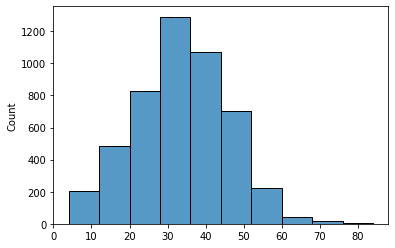

In [17]:
# TO USE THE TOKENIZER WE NEED TO CHECK THE MAX LENGHT OF THE SENTENCES (ONCE SPLITTED IN TOKEN IDS)
# Making list of sentence lenghts:

def get_list_of_lengths(text_column, tokenizer) -> int:

  token_lens = []
  
  for text in text_column:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens => split in symbolic/textual tokens and map them to integer ids
    tokens = tokenizer.encode(text, add_special_tokens=True)
    
    #checking the len of tokenized sentence
    token_lens.append(len(tokens))

  return token_lens

def get_max_lenghts(list_len) -> int:

  # PART 1 MAX

  # Convert the list to a PyTorch tensor
  tensor_data = torch.tensor(list_len)
  
  # getting the argmax index
  argmax_index = tensor_data.argmax().item()

  # getting the argmax

  argmax = list_len[argmax_index]
  print(f"The longest input sequence has value: {argmax}")
  
  # PART 2 HISTOGRAM

  # importing the library for the visualization
  import seaborn as sns

  #now we want to plot the histogram of the list of integers
  sns.histplot(list_len, bins=10)

  return argmax

max_length = get_max_lenghts(get_list_of_lengths(ds_train["text"], tokz))

In [18]:
# DEFINING A TOKENIZE FUNCTION TO TOKENIZE BOTH THE TWO DATASETS
def tok_func(x): return tokz(x["text"], truncation=True, padding = "max_length", max_length=max_length)

In [19]:
# CHECK THAT TOKENIZER FUNCTION WORKS
tok_func(ds_train[19]) # the 1 are for padding it; the attention mask show to not care about the 1

{'input_ids': [101, 5776, 1011, 2988, 13105, 1999, 2146, 1011, 2744, 8643, 1997, 18804, 16677, 3609, 22471, 2389, 4456, 1011, 2329, 3485, 1997, 5970, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 1019, 8516, 2549, 16409, 2487, 2102, 4160, 2102, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [20]:
# TOKENIZING THE DS
tok_ds_train = ds_train.map(tok_func, batched=True, remove_columns=['text'])
tok_ds_validation = ds_validation.map(tok_func, batched=True, remove_columns=['text'])
tok_ds_test = ds_test.map(tok_func, batched=True, remove_columns=['text'])
tok_ds_validation

Map:   0%|          | 0/4872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1218 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1218
})

In [21]:
tok_ds_validation

Dataset({
    features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1218
})

### CONVERTING TO PYTORCH DATASETS

In [22]:
# Define a function to convert each item in the dataset to a PyTorch-compatible format
def convert_to_torch(item):
    input_ids = item['input_ids']
    token_type_ids = item['token_type_ids']
    attention_mask = item['attention_mask']
    label = item['labels']
    return {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask, 'label': label}

In [23]:
# Use the `map()` method to apply the `convert_to_torch()` function to each item in the dataset
tok_ds_train = tok_ds_train.map(convert_to_torch, batched=True)


Map:   0%|          | 0/4872 [00:00<?, ? examples/s]

In [24]:
# Convert the dataset to a PyTorch TensorDataset by simply transforming each numerical column of the dataset in tensor
tensor_train_dataset = torch.utils.data.TensorDataset(torch.tensor(tok_ds_train['input_ids']),
                                                torch.tensor(tok_ds_train['token_type_ids']),
                                                torch.tensor(tok_ds_train['attention_mask']),
                                                torch.tensor(tok_ds_train['label']))

In [25]:
# SAME FOR VALIDATION SET

# Use the `map()` method to apply the `convert_to_torch()` function to each item in the dataset
tok_ds_validation = tok_ds_validation.map(convert_to_torch, batched=True)

# Convert the dataset to a PyTorch TensorDataset
tensor_validation_dataset = torch.utils.data.TensorDataset(torch.tensor(tok_ds_validation['input_ids']),
                                                torch.tensor(tok_ds_validation['token_type_ids']),
                                                torch.tensor(tok_ds_validation['attention_mask']),
                                                torch.tensor(tok_ds_validation['label']))


Map:   0%|          | 0/1218 [00:00<?, ? examples/s]

In [26]:
# SAME FOR TEST SET

# Use the `map()` method to apply the `convert_to_torch()` function to each item in the dataset
tok_ds_test = tok_ds_test.map(convert_to_torch, batched=True)

# Convert the dataset to a PyTorch TensorDataset
tensor_test_dataset = torch.utils.data.TensorDataset(torch.tensor(tok_ds_test['input_ids']),
                                                torch.tensor(tok_ds_test['token_type_ids']),
                                                torch.tensor(tok_ds_test['attention_mask']),
                                                torch.tensor(tok_ds_test['label']))


Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

### PLUGGING INTO DATALOADERS

In [27]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [28]:
train_dataloader = DataLoader(
            tensor_train_dataset,  # The training samples.
            sampler = RandomSampler(tensor_train_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            tensor_validation_dataset,  # The training samples.
            sampler = RandomSampler(tensor_validation_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size.
        )

test_dataloader = DataLoader(
            tensor_test_dataset,  # The training samples.
            sampler = RandomSampler(tensor_test_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size.
        )

### CREATING THE MODULE OF THE MODEL

The BertForSequenceClassification model's predict() method will take a batch of input sequences as input, and will return a tuple of two elements:

logits: A tensor of shape (batch_size, num_labels) containing the unnormalized scores for each label. These scores can be interpreted as a measure of the model's confidence in its prediction for each label.

hidden_states: A tuple of length num_hidden_layers+1 containing the hidden states of the model for each layer. Each hidden state tensor is of shape (batch_size, sequence_length, hidden_size).

Note that the predict() method doesn't perform any thresholding or decision-making based on the logits. The user needs to apply their own thresholding or decision-making logic based on the specific requirements of their task.

We are interested in:
- its logits, for the classification

That s all **so we should not return any hidden state**

In [29]:
# creating a pytorch module => that is a block of parameters and computation (forward)
import torch.nn as nn

class Bert4BinaryClassification(nn.Module):

  # initiliazer, specify the name of the bert model you want to load
    def __init__(self,model_name):

      # be sure the nn.Module is correctly 
        super().__init__()  

      # initialize the model (think to it as a cooler sequential(...))
        self.model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 2).to(getting_device())

  # forward method, we need to feed it with the tokenized text (ids + attention mask)
    def forward(self,input_ids,attention_mask):

      # pass the tokenized test through the model, which has as last layer a FNN with 2 output perceptrons
        output = self.model(input_ids=input_ids,attention_mask=attention_mask)

      # gather the 2 entries output vector
        logits = output.logits

      # return it
        return logits

  # implement the gpu util function as a method so it move directly the model on the gpu
    def getting_device(self,gpu_prefence=True):
      """
      This function gets the torch device to be used for computations, 
      based on the GPU preference specified by the user.
      """
      
      # If GPU is preferred and available, set device to CUDA
      if gpu_prefence and torch.cuda.is_available():
          device = torch.device('cuda')
      # If GPU is not preferred or not available, set device to CPU
      else: 
          device = torch.device("cpu")
      
      # Print the selected device
      print(f"Selected device for BERTBINARYCLASSIFICATION: {device}")
      
      # Return the device
      return device


In [30]:
model = Bert4BinaryClassification(model_nm)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

Selected device: cuda


In [31]:
# checking if the model is on the gpu
print_gpu_utilization()

GPU memory occupied: 2353 MB.


### EXPLORING THE MODEL COMPUTATIONAL GRAPH 

First, we begin with printing the layer of the model

In [32]:
print(model)

Bert4BinaryClassification(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=1024, out

The last part of the model is the most interersting one; check how there is a linear layer that transformer the last hidden feature vector, whose dimensionality is 1024, to a feature vector with 2 entries. So for each input (initial feature vectors of n entries representing a datapoint) we will have a final feature vector with 2 entries. Each entry encode a quantification (probability if activated with either a sigmoid or a softmax) of our input to be one of the two possible classes (disaster or not). 

Another way to visualize our model is to use **torchview**, a library inspired by **torchviz** and made to work with hf models. It allows to draw the computational graph of our model  

In [33]:
# FIRSTLY BE SURE TO HAVE INSTALLED THE REQUIRED MODULE
!pip install torchview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


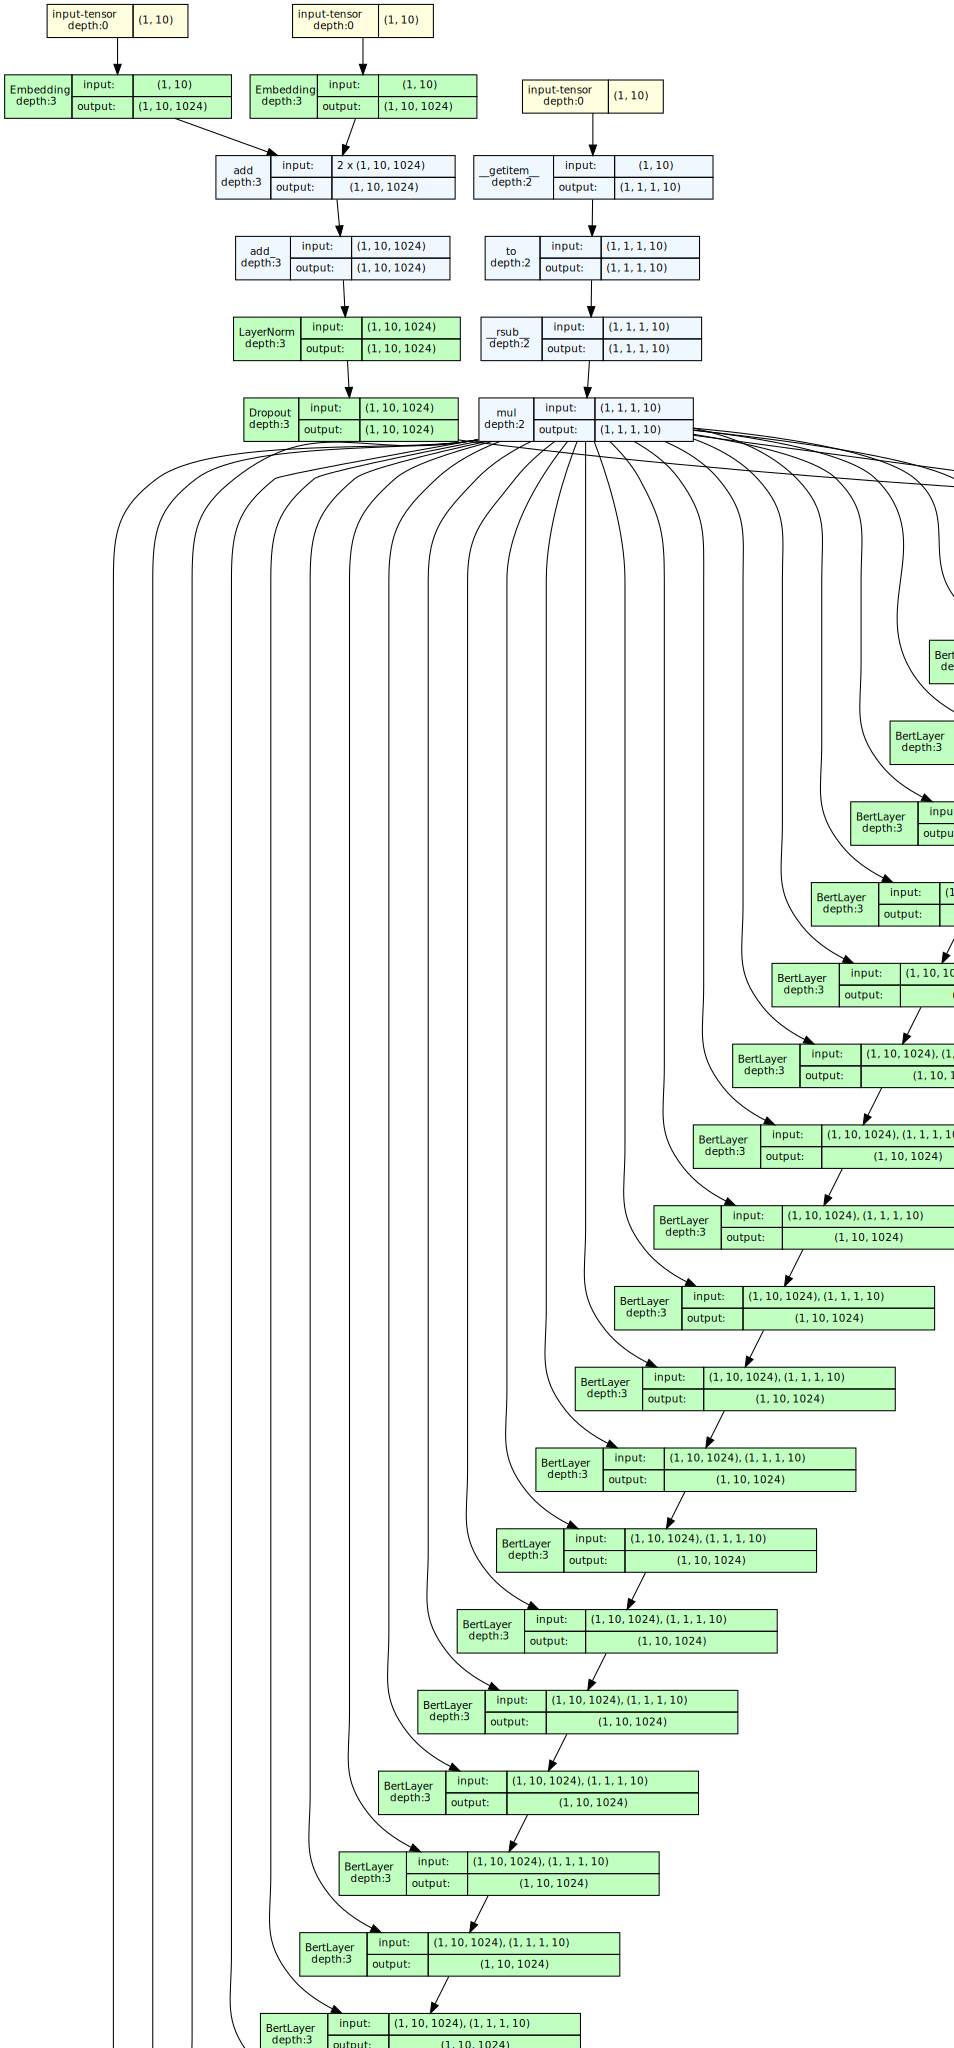

In [34]:

from torchview import draw_graph

inputs = tokz("This is a fake disaster tweet", return_tensors="pt")

model_graph = draw_graph(model.model, input_data=inputs)

model_graph.visual_graph


### DEFINING METRICS

If we use the Trainer API to fine tune our model, we must define the metric function and pass it as one of the trainer argument; the trainer does not compute the metrics in automatic. Given the lack of class imbalance and cost imbalance, we will deploy Accuracy as evaluation strategy

In [35]:
import numpy as np 
import evaluate 

In [36]:
# we create an object called metrics; if the method "compute" is called and we pass in a list of predictions and true labels, it automatically compute them
metrics = evaluate.load("accuracy")

In [37]:
# now that we have our callable object, we define a function that the trainer can use to compute its metric => we cannot call directly metrics.compute because the output
# of the model is not a prediction but a logist
def compute_accuracy(logists, true_labels):

  # transforming logists in prediction by picking; -1 applies argmax along the last axis of the input array 
  predictions = np.argmax(logists, axis = -1)    

  # computing the accuracy
  accuracy_score = metrics.compute(predictions=predictions, references=true_labels)

  return accuracy_score

### DEFINING LOSS FUNCTION

In [38]:
# loss function

import torch.nn as nn

loss_fn = nn.CrossEntropyLoss() # input => (predicted probab positive class, positive or negative class)

### IMPORTING THE OPTIMIZER (HYPERPARAMETER CAN BE CHANGE OR OPTIMIZER CAN BE CHANGED)

Some context on what we will do

As an optimizer we will use **AdamW**: AdamW modifies the weight decay term in the Adam optimizer to improve the convergence of the model during training. This modification can help to prevent overfitting and improve the generalization of the model.

**Weight decay** is a regularization technique used to prevent overfitting in machine learning models by adding a penalty term to the loss function. An example are L2 and L1 regularization, where the loss of model is penalized based on the dimension of the weight (the bigger, the more penality)

**Epsilon value** is a small positive value that is added to the denominator of a division operation in optimization algorithms such as Adam and RMSprop. The epsilon value is used to prevent division by zero and stabilize the optimization process. In practice, the epsilon value is typically set to a small value such as 1e-8 or 1e-10. 

In [39]:
# PICKING HYPERPARAMETERS FOR OPTIMIZER 

learning_rate_hp1 = 6e-6 # standard 

epsilon_value_hp2 = 1e-8 # standard 

In [40]:
# SETTING UP THE OPTIMIZER =

# it is a transformer class, it requires two argument, a.k.a the parameters it needs to update at each step and the learning rate to scale the gradient

optimizer1 = AdamW(model.parameters(),
                  lr = learning_rate_hp1, # args.learning_rate
                  eps = epsilon_value_hp2 # args.adam_epsilon
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### LEARNING RATE SCHEDULER 

The **learning rate** is a hyperparameter that controls how much the model's parameters are updated during training. The *scheduling technique* adjusts the learning rate over the course of training to improve model performance.

The **get_linear_schedule_with_warmup** function is a built-in method in the PyTorch library that returns a learning rate scheduler. This scheduler increases the learning rate linearly from 0 during a warm-up period, and then decreases it linearly to 0 over the remaining training steps. The warm-up period is a number of training steps at the beginning of the training process where the learning rate is gradually increased from 0 to its initial value, allowing the model to start with smaller steps and avoid destabilizing the optimization process.

The function takes several arguments, including the optimizer, the total number of training steps, the warm-up proportion (the proportion of training steps used for the warm-up period), and an optional argument for controlling the degree of decay of the learning rate. 



In [41]:
# SETTING ANOTHER HYPERPARAMETER
epochs_hp3 = 3

# Total number of training steps is the number of steps per epoch times the number of epochs
total_steps = len(train_dataloader) * epochs_hp3

# Last Hyperparameter, the warm up steps

warmup_steps_hp4 = 0 # so just decay not increasing of learning rate, seems to be standard

In [42]:
# CREATING THE SCHEDULER
scheduler = get_linear_schedule_with_warmup(optimizer1, num_warmup_steps = warmup_steps_hp4,num_training_steps = total_steps)

### DEFINING TRAINING FUNCTION

library used for visualization => tqdm => tqdm is a popular Python library that provides a progress bar for loops and iterators. It is especially useful when iterating over large datasets or performing long-running operations where it's helpful to have an indication of progress. You can use tqdm in your code by wrapping an iterator or loop with the "tqdm()" function. A tqdm will automatically create a progress bar that shows the percentage of items completed, the estimated time remaining, and other information. As the loop iterates, the progress bar will update accordingly.

library used for cleaning memory => gc => gc.collect() simply remove from memory everything we are not using (not reference anymore by variables)

In [43]:
!pip install tqdm
from tqdm.auto import tqdm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
def train(model, train_dataloader, loss_fn, optimizer, scheduler):
    """
    This function trains a given model on training data and validates on validation data
    """
    # setting the model to training mode => important because it says to compute gradients 4 backwards pass, while computing the forward pass
    model.train()

    # wrapping tqdm around the dataloader to allow visualization
    visual_train_dl = tqdm(train_dataloader)

    # initiliaze it to compute the training loss after all the batches 
    total_train_loss = 0

    # initialize for printing near the bar
    train_step = 0

    # iterate over the batch of the data loader (after all iteration we made 1 epoch)
    for batch in visual_train_dl:

      # accessing batch (contains an input_ids, an attention mask, and a label)
      batch_ids = batch[0].to(device)
      batch_attention_mask = batch[2].to(device)
        # squeeze remove dimension because labels should not have dimension, long transform in long integer as required by pytorch
      batch_labels = batch[3].squeeze().to(device).long()

      # step 1: reset optimizer stored gradient
      optimizer.zero_grad()

      # step 2: model logists through forward pass => remember the forward return logists
      logits = model(batch_ids, batch_attention_mask).to(device)

      # step 3: take the argmax index aka the predicted class index
      predictions = torch.argmax(logits, dim=1) 

      #detached_predictions = predictions.detach().cpu().numpy()

      # step 4: compute the loss => takes as input the logist aka the predicted probability, not the predicted class
      loss = loss_fn(logits, batch_labels)
        # needed for printing stats
      total_train_loss += loss.item()
      train_step += 1

      # step 5: compute the gradient (derivative of the loss over every trainable parameter)
      loss.backward() 

      # step 6: advance the optimizer and the scheduler
      optimizer.step()
      scheduler.step()

      # The set_postfix() method of the progress bar updates the message displayed in the progress bar to include the specified key-value pairs
      visual_train_dl.set_postfix({'train_loss':total_train_loss/train_step}) 
    visual_train_dl.close()

    # Calculate the average loss over all of the batches.
    
    final_avg_train_loss = total_train_loss / train_step            
    
    print('')
    print('  Average training loss: {0:.2f}'.format(final_avg_train_loss))

### DEFINING THE VALIDATION FUNCTION

In [45]:
def validate(model,valid_dataloader,loss_fn):

    # step 1, say to the model that computing the forward is enough, no backward!
    with torch.no_grad():

        # step 2, say to the model that it is validation time (4 dropout and normalization)
        model.eval()

        # initiliaze it to compute the training loss after all the batches 
        total_valid_loss = 0

        # initiliaze to compute the avg thereafter
        valid_step = 0

        # list for accuracy
        correct = 0

        # wrapper for progress bar
        visual_valid_dl = tqdm(valid_dataloader)
  
        # iterate over the batch of the data loader (after all iteration we made 1 epoch)
        for batch in visual_valid_dl:

            # update the step 
            valid_step += 1

            # accessing batch (contains an input_ids, an attention mask, and a label)
            batch_ids = batch[0].to(device)
            batch_attention_mask = batch[2].to(device)

            # squeeze remove dimension because labels should not have dimension, long transform in long integer as required by pytorch
            batch_labels = batch[3].squeeze().to(device).long()

            # step 3: model logists through forward pass => remember the forward return logists
            logits = model(batch_ids, batch_attention_mask).to(device)

            # step 4: getting predictions
            predictions = torch.argmax(logits, dim=1)

            # step 5: check if correct
            correct += (predictions == batch_labels).type(torch.float).sum().item()
           
           #detached_predictions = predictions.detach().cpu().numpy()

            # step 5: computing the loss
            loss = loss_fn(logits, batch_labels)

            # step 6: add to total loss
            total_valid_loss += loss.item()

        total_valid_loss /= valid_step
        accuracy = correct / len(valid_dataloader.dataset)

        print(f'Accuracy Score: {accuracy}')
        print(f'Valid_loss: {total_valid_loss}')


In [46]:
import torch
from sklearn.metrics import f1_score

def test_with_f1(model,test_dataloader,loss_fn):

    # step 1, say to the model that computing the forward is enough, no backward!
    with torch.no_grad():

        # step 2, say to the model that it is validation time (4 dropout and normalization)
        model.eval()

        # initiliaze it to compute the training loss after all the batches 
        total_test_loss = 0

        # initiliaze to compute the avg thereafter
        test_step = 0

        # list for accuracy
        correct = 0
        
        # list for predictions and true labels
        all_predictions = []
        all_labels = []

        # wrapper for progress bar
        visual_test_dl = tqdm(test_dataloader)
  
        # iterate over the batch of the data loader (after all iteration we made 1 epoch)
        for batch in visual_test_dl:

            # update the step 
            test_step += 1

            # accessing batch (contains an input_ids, an attention mask, and a label)
            batch_ids = batch[0].to(device)
            batch_attention_mask = batch[2].to(device)

            # squeeze remove dimension because labels should not have dimension, long transform in long integer as required by pytorch
            batch_labels = batch[3].squeeze().to(device).long()

            # step 3: model logists through forward pass => remember the forward return logists
            logits = model(batch_ids, batch_attention_mask).to(device)

            # step 4: getting predictions
            predictions = torch.argmax(logits, dim=1)
            
            # append predictions and labels to lists
            all_predictions.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(batch_labels.cpu().numpy().tolist())

            # step 5: check if correct
            correct += (predictions == batch_labels).type(torch.float).sum().item()
           
           #detached_predictions = predictions.detach().cpu().numpy()

            # step 5: computing the loss
            loss = loss_fn(logits, batch_labels)

            # step 6: add to total loss
            total_test_loss += loss.item()

        total_test_loss /= test_step
        accuracy = correct / len(test_dataloader.dataset)
        f1 = f1_score(all_labels, all_predictions, average='macro')
        
        print(f'Accuracy Score: {accuracy}')
        print(f'F1 Score: {f1}')
        print(f'Test_loss: {total_test_loss}')


### TRAING/VALIDATE PASS

In [47]:
for t in range(epochs_hp3):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model = model, train_dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer1, scheduler = scheduler)
    validate(model = model,valid_dataloader = validation_dataloader,loss_fn = loss_fn)
print("Done!")

Epoch 1
-------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]


  Average training loss: 0.54


  0%|          | 0/39 [00:00<?, ?it/s]

Accuracy Score: 0.8341543513957307
Valid_loss: 0.4217968395887277
Epoch 2
-------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]


  Average training loss: 0.39


  0%|          | 0/39 [00:00<?, ?it/s]

Accuracy Score: 0.8472906403940886
Valid_loss: 0.388557174266913
Epoch 3
-------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]


  Average training loss: 0.35


  0%|          | 0/39 [00:00<?, ?it/s]

Accuracy Score: 0.8456486042692939
Valid_loss: 0.4405317367651524
Epoch 4
-------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]


  Average training loss: 0.32


  0%|          | 0/39 [00:00<?, ?it/s]

Accuracy Score: 0.8382594417077176
Valid_loss: 0.38442602295141953
Epoch 5
-------------------------------


  0%|          | 0/153 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### TESTING THE MODEL

In [48]:
test_with_f1(model = model,valid_dataloader = test_dataloader,loss_fn = loss_fn)
print("Done!")

  0%|          | 0/48 [00:00<?, ?it/s]

Accuracy Score: 0.835193696651346
F1 Score: 0.8272800262780622
Valid_loss: 0.4007938023035725
Done!


### SAVING THE MODEL

In [49]:
import torchvision.models as models

In [ ]:
model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# for loading 

'''model = models.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()'''